<a href="https://www.kaggle.com/code/tarekmasryo/ev-charging-stations-eda?scriptVersionId=292228660" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<style>
:root{
  --ink:#0f172a;
  --muted:#475569;
  --border:rgba(15,23,42,0.18);
  --shadow:0 24px 60px rgba(2,6,23,0.10);
  --bg:
    radial-gradient(900px 500px at 0% 0%, rgba(2,132,199,0.18) 0, transparent 55%),
    linear-gradient(135deg, #ffffff 0%, #f1f5f9 55%, #ffffff 100%);
}
@media (prefers-color-scheme: dark){
  :root{
    --ink:#eaf2ff;
    --muted:#9ca3af;
    --border:rgba(148,163,184,0.55);
    --shadow:0 24px 60px rgba(15,23,42,0.85);
    --bg:
      radial-gradient(900px 500px at 0% 0%, rgba(37,99,235,0.35) 0, transparent 55%),
      linear-gradient(135deg, #020617 0%, #02091f 55%, #020617 100%);
  }
}
html[data-color-mode="dark"],
html[data-theme="dark"],
body[data-theme="dark"],
body.theme-dark,
html.theme-dark{
  --ink:#eaf2ff;
  --muted:#9ca3af;
  --border:rgba(148,163,184,0.55);
  --shadow:0 24px 60px rgba(15,23,42,0.85);
  --bg:
    radial-gradient(900px 500px at 0% 0%, rgba(37,99,235,0.35) 0, transparent 55%),
    linear-gradient(135deg, #020617 0%, #02091f 55%, #020617 100%);
}
html[data-color-mode="light"],
html[data-theme="light"],
body[data-theme="light"],
body.theme-light,
html.theme-light{
  --ink:#0f172a;
  --muted:#475569;
  --border:rgba(15,23,42,0.18);
  --shadow:0 24px 60px rgba(2,6,23,0.10);
  --bg:
    radial-gradient(900px 500px at 0% 0%, rgba(2,132,199,0.18) 0, transparent 55%),
    linear-gradient(135deg, #ffffff 0%, #f1f5f9 55%, #ffffff 100%);
}
.kgl-hero{
  background:var(--bg) !important;
  color:var(--ink) !important;
  border-radius:26px;
  padding:36px 40px;
  border:1px solid var(--border) !important;
  box-shadow:var(--shadow) !important;
  line-height:1.7;
}
.kgl-hero *{ color:var(--ink) !important; }
.kgl-hero .kgl-muted{ color:var(--muted) !important; }
</style>

<div class="kgl-hero">

  <h2 style="margin:0 0 6px 0; font-size:30px; font-weight:800; letter-spacing:0.03em;">
    Global EV Charging Stations + EV Models 
  </h2>

  <p class="kgl-muted" style="margin:0 0 18px 0; font-size:18px; font-weight:600;">
    Exploratory Analysis &amp; Infrastructure Insights
  </p>

  <p style="margin:0 0 16px 0; font-size:15px;">
    This notebook explores the <b>Global EV Charging Stations + EV Models</b> dataset and links
    charging infrastructure to the underlying electric vehicle model ecosystem.
  </p>

  <p style="margin:0 4px 6px 0; font-size:15px;">We will:</p>
  <ul style="margin:0 0 18px 1.1rem; padding-left:1.1rem; font-size:15px;">
    <li>Inspect all tables (station-level records, country summaries, EV models, and city-level features).</li>
    <li>Build a country-level infrastructure profile (coverage, fast-charging share, ports, and power levels).</li>
    <li>Visualize the global distribution of stations and power tiers across countries and cities.</li>
    <li>Explore EV model timelines, brands, and body styles to understand how supply is evolving.</li>
    <li>Train a simple city-level baseline model to predict the presence of fast DC infrastructure.</li>
  </ul>

  <p style="margin:0; font-size:15px;">
    The goal is to provide a clear, reproducible view of the 2025 EV charging landscape and show
    how this dataset can support infrastructure analysis, planning, and baseline ML experiments.
  </p>

</div>


## Imports, plotting config, and helper functions
 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

# Plot style
plt.rcParams["figure.figsize"] = (11, 5.5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
sns.set_style("whitegrid")

SEED = 42
rng = np.random.default_rng(SEED)

def section(title, subtitle=None):
    """Render a markdown section header from inside a code cell."""
    text = f"## {title}"
    if subtitle:
        text += f"\n\n{subtitle}"
    display(Markdown(text))

def hr():
    """Horizontal rule in markdown."""
    display(Markdown("---"))


#  Load Data

In [2]:
charging = pd.read_csv("/kaggle/input/global-ev-charging-stations/charging_station.csv")
country = pd.read_csv("/kaggle/input/global-ev-charging-stations/country_summary.csv")
ev_models = pd.read_csv("/kaggle/input/global-ev-charging-stations/ev_models.csv")
world = pd.read_csv("/kaggle/input/global-ev-charging-stations/world_summary.csv")
city = pd.read_csv("/kaggle/input/global-ev-charging-stations/charging_station_ml.csv")

section("Dataset overview", "First look at all tables: stations, cities, countries, and EV models.")


## Dataset overview

First look at all tables: stations, cities, countries, and EV models.

In [3]:
section("Global snapshot", "High-level KPIs before diving into plots.")

def pct(x):
    return f"{x*100:.1f}%"

countries_covered = charging["country_code"].nunique()
cities_covered = charging["city"].nunique()
fast_share_global = charging["is_fast_dc"].mean()
max_power = charging["power_kw"].max()
p99_power = charging["power_kw"].quantile(0.99)

top_make_counts = ev_models["make"].value_counts()
top_make = top_make_counts.idxmax() if len(top_make_counts) else None
top_make_n = top_make_counts.max() if len(top_make_counts) else 0

kpi = pd.DataFrame(
    {
        "Metric": [
            "Total stations",
            "Countries with stations",
            "Cities with stations",
            "Global fast DC share",
            "Max site power (kW)",
            "99th percentile site power (kW)",
            "Top EV make by number of models",
        ],
        "Value": [
            f"{len(charging):,}",
            f"{countries_covered}",
            f"{cities_covered}",
            pct(fast_share_global),
            f"{max_power:,.0f}",
            f"{p99_power:,.0f}",
            f"{top_make} ({top_make_n})" if top_make is not None else "N/A",
        ],
    }
)

display(kpi)
hr()


## Global snapshot

High-level KPIs before diving into plots.

,Metric,Value
0,Total stations,"242,417"
1,Countries with stations,121
2,Cities with stations,41816
3,Global fast DC share,21.0%
4,Max site power (kW),"1,000,000"
5,99th percentile site power (kW),350
6,Top EV make by number of models,BMW (7)


---

## Basic structure overview for each table

In [4]:
section("Table structures", "Shapes, heads, and basic statistics for each table.")

def summarize(df, name):
    print(f"=== {name} ===")
    print("Shape:", df.shape, "\n")
    print("Head:")
    display(df.head(3))
    print("\nDescribe (first 10 rows):")
    display(df.describe(include="all").transpose().head(10))
    print("\n" + "="*70 + "\n")

summarize(charging, "Charging stations (site-level)")
summarize(city,     "City-level infrastructure (city table)")
summarize(country,  "Country summary (compact)")
summarize(world,    "Country infrastructure profile (detailed)")
summarize(ev_models,"EV models")

hr()


## Table structures

Shapes, heads, and basic statistics for each table.

=== Charging stations (site-level) ===
Shape: (242417, 11) 

Head:


,id,name,city,state_province,country_code,latitude,longitude,ports,power_kw,power_class,is_fast_dc
0,307660,Av. de Tarragona,Andorra,UNKNOWN,AD,42.505254,1.528861,10,300.0,DC_ULTRA_(>=150kW),True
1,301207,Parquing Costa Rodona,Encamp,UNKNOWN,AD,42.537213,1.727014,10,22.0,AC_HIGH_(22-49kW),False
2,301206,Hotel Naudi,Unknown City,UNKNOWN,AD,42.576811,1.666061,1,11.0,AC_L2_(7.5-21kW),False



Describe (first 10 rows):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,242417.0,NaN,NaN,NaN,204039.926519,101789.186799,2389.0,122882.0,208085.0,280795.0,460650.0
name,242417,225282,Shell Recharge/Ubitricity,1166,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,242417,41816,Unknown City,22189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state_province,242417,5989,UNKNOWN,69998,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_code,242417,121,US,82138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,242417.0,NaN,NaN,NaN,43.253894,12.692335,-55.811599,38.859333,44.414623,51.41389,81.736061
longitude,242417.0,NaN,NaN,NaN,-32.07416,57.652645,-164.848855,-81.644018,-2.867264,7.883693,178.369254
ports,242417.0,NaN,NaN,NaN,1.959277,3.931007,-4.0,1.0,1.0,2.0,503.0
power_kw,237757.0,NaN,NaN,NaN,35.253735,2051.557432,0.0,3.7,11.0,22.0,1000000.0
power_class,242417,6,AC_L1_(<7.5kW),107144,NaN,NaN,NaN,NaN,NaN,NaN,NaN




=== City-level infrastructure (city table) ===
Shape: (58642, 17) 

Head:


,country_code,state_province,city,latitude,longitude,station_count,port_count,fast_station_count,fast_port_count,fast_station_share,fast_port_share,max_power_kw,median_power_kw,dc_fast_station_count,dc_ultra_station_count,has_fast_dc,has_ultra_dc
0,AD,Andorra la Vella,Andorra la Vella,42.506880,1.527992,2,4,0,0,0.0,0.0,22.0,22.0,0,0,0,0
1,AD,Andorra la Vella,Santa Coloma,42.496959,1.500966,1,2,0,0,0.0,0.0,22.0,22.0,0,0,0,0
2,AD,Canillo,Canillo,42.565901,1.598916,1,2,0,0,0.0,0.0,22.0,22.0,0,0,0,0



Describe (first 10 rows):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country_code,58642,121,US,11735,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state_province,58642,5989,UNKNOWN,14371,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,58642,41816,Unknown City,851,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,58642.0,NaN,NaN,NaN,42.631447,17.59913,-55.811599,40.265816,46.142685,51.469244,81.736061
longitude,58642.0,NaN,NaN,NaN,-11.989939,55.369284,-164.848855,-69.836675,2.291041,11.504978,178.369254
station_count,58642.0,NaN,NaN,NaN,4.133846,55.383509,1.0,1.0,1.0,2.0,10354.0
port_count,58642.0,NaN,NaN,NaN,8.099349,72.007791,-4.0,1.0,2.0,6.0,10594.0
fast_station_count,58642.0,NaN,NaN,NaN,0.866836,4.226317,0.0,0.0,0.0,1.0,446.0
fast_port_count,58642.0,NaN,NaN,NaN,2.532963,15.983856,0.0,0.0,0.0,2.0,2126.0
fast_station_share,58642.0,NaN,NaN,NaN,0.295128,0.41402,0.0,0.0,0.0,0.6,1.0




=== Country summary (compact) ===
Shape: (121, 6) 

Head:


,country_code,country,station_count,port_count,fast_station_share,fast_port_share
0,AD,Andorra,96,259,0.062500,0.138996
1,AE,United Arab Emirates,131,346,0.175573,0.410405
2,AF,Afghanistan,1,1,0.000000,0.000000



Describe (first 10 rows):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country_code,121,121,AD,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,121,121,Andorra,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
station_count,121.0,NaN,NaN,NaN,2003.446281,8453.87178,1.0,6.0,55.0,555.0,82138.0
port_count,121.0,NaN,NaN,NaN,3925.305785,13604.923284,1.0,11.0,85.0,993.0,113480.0
fast_station_share,121.0,NaN,NaN,NaN,0.348301,0.305622,0.0,0.128514,0.29009,0.5,1.0
fast_port_share,121.0,NaN,NaN,NaN,0.383318,0.312498,0.0,0.137931,0.366667,0.593114,1.0




=== Country infrastructure profile (detailed) ===
Shape: (121, 12) 

Head:


,country_code,country,station_count,port_count,fast_station_count,fast_port_count,fast_station_share,fast_port_share,max_power_kw,median_power_kw,dc_fast_station_count,dc_ultra_station_count
0,AD,Andorra,96,259,6,36,0.062500,0.138996,300.0,22.0,6,2
1,AE,United Arab Emirates,131,346,23,142,0.175573,0.410405,250.0,22.0,23,16
2,AF,Afghanistan,1,1,0,0,0.000000,0.000000,22.0,22.0,0,0



Describe (first 10 rows):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country_code,121,121,AD,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,121,121,Andorra,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
station_count,121.0,NaN,NaN,NaN,2003.446281,8453.87178,1.0,6.0,55.0,555.0,82138.0
port_count,121.0,NaN,NaN,NaN,3925.305785,13604.923284,1.0,11.0,85.0,993.0,113480.0
fast_station_count,121.0,NaN,NaN,NaN,420.107438,1539.493271,0.0,1.0,21.0,170.0,14299.0
fast_port_count,121.0,NaN,NaN,NaN,1227.586777,4306.01785,0.0,1.0,36.0,417.0,37309.0
fast_station_share,121.0,NaN,NaN,NaN,0.348301,0.305622,0.0,0.128514,0.29009,0.5,1.0
fast_port_share,121.0,NaN,NaN,NaN,0.383318,0.312498,0.0,0.137931,0.366667,0.593114,1.0
max_power_kw,117.0,NaN,NaN,NaN,8784.820513,92428.093157,10.0,75.0,180.0,360.0,1000000.0
median_power_kw,117.0,NaN,NaN,NaN,48.840171,97.520472,3.7,22.0,22.0,50.0,1000.0




=== EV models ===
Shape: (128, 8) 

Head:


,make,model,market_regions,powertrain,first_year,body_style,origin_country,age_2025
0,Tesla,Model S,Global (US/EU/UK/ME),BEV,2012,Sedan,US,13
1,Tesla,Model 3,Global (US/EU/UK/ME/CN),BEV,2017,Sedan,US,8
2,Tesla,Model X,Global (US/EU/UK/ME),BEV,2015,SUV,US,10



Describe (first 10 rows):


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
make,128,50,BMW,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,128,127,500e,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
market_regions,128,40,EU/UK,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN
powertrain,128,1,BEV,128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_year,128.0,NaN,NaN,NaN,2021.382812,2.262746,2010.0,2020.0,2022.0,2023.0,2025.0
body_style,128,17,SUV,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origin_country,128,25,China,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_2025,128.0,NaN,NaN,NaN,3.617188,2.262746,0.0,2.0,3.0,5.0,15.0


---

## Country summary table 

,country_code,country,station_count,port_count,fast_station_share,fast_port_share
0,AD,Andorra,96,259,0.062500,0.138996
1,AE,United Arab Emirates,131,346,0.175573,0.410405
2,AF,Afghanistan,1,1,0.000000,0.000000
3,AL,Albania,15,16,0.600000,0.562500
4,AM,Armenia,4,6,0.250000,0.166667


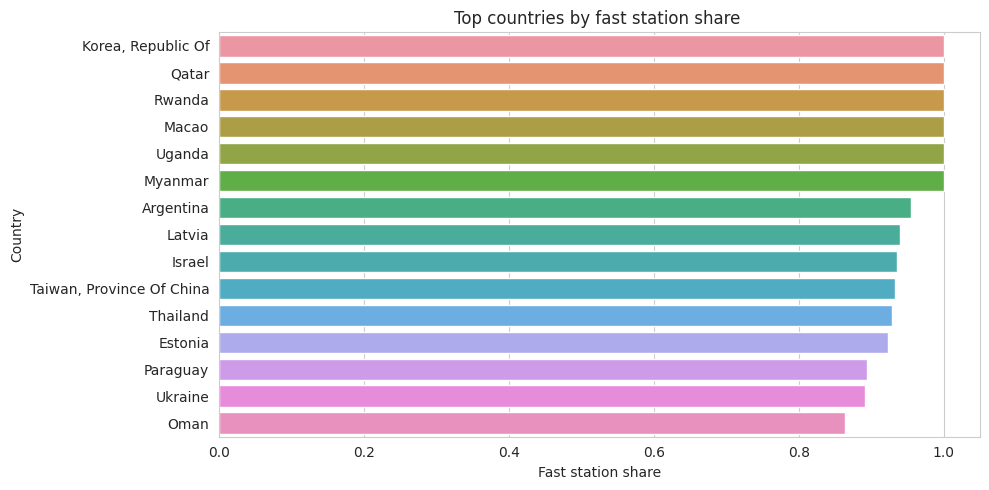

---

In [5]:
section("Country summary table ")

display(country.head())

plt.figure(figsize=(10,5))
top_country_fast = country.sort_values("fast_station_share", ascending=False).head(15)
sns.barplot(
    data=top_country_fast,
    x="fast_station_share",
    y="country",
)
plt.title("Top countries by fast station share ")
plt.xlabel("Fast station share")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

hr()


## Data quality checks & light cleaning



In [6]:
section("Data quality and cleaning", "Missing values, duplicates, types, and basic normalization.")

print("Missing values per table:\n")
for df, name in [
    (charging, "Charging"),
    (country, "Country"),
    (city, "City"),
    (ev_models, "EV Models"),
    (world, "World")
]:
    print(f"{name}:")
    display(df.isna().sum())
    print()

print("Duplicate rows:")
print("Charging:", charging.duplicated().sum())
print("Country:", country.duplicated().sum())
print("City:", city.duplicated().sum())
print("EV Models:", ev_models.duplicated().sum())
print("World:", world.duplicated().sum())

# ---- Cleaning (conservative) ----

# Normalize city/state text for missing values
charging["city"] = charging["city"].fillna("Unknown City")
charging["state_province"] = charging["state_province"].fillna("UNKNOWN")

# Ensure country_code exists for stations and countries
charging = charging.dropna(subset=["country_code"])
country = country.dropna(subset=["country_code"])

# Ensure numeric types
charging["power_kw"] = pd.to_numeric(charging["power_kw"], errors="coerce")
charging["ports"] = pd.to_numeric(charging["ports"], errors="coerce")

# Remove impossible coordinates
before_geo = len(charging)
charging = charging[
    charging["latitude"].between(-90, 90)
    & charging["longitude"].between(-180, 180)
]
after_geo = len(charging)
print(f"\nRemoved {before_geo - after_geo:,} rows with invalid coordinates.")

# Fill remaining NaN in power_kw with median (for plots)
power_median = charging["power_kw"].median()
charging["power_kw"] = charging["power_kw"].fillna(power_median)

# Cast to appropriate dtypes
charging["country_code"] = charging["country_code"].astype("category")
if "power_class" in charging.columns:
    charging["power_class"] = charging["power_class"].astype("category")

charging["is_fast_dc"] = charging["is_fast_dc"].astype(bool)

print("\nFinal shapes after cleaning:")
print("Charging:", charging.shape)
print("Country:", country.shape)
print("City:", city.shape)
print("World:", world.shape)
print("EV Models:", ev_models.shape)

hr()


## Data quality and cleaning

Missing values, duplicates, types, and basic normalization.

Missing values per table:

Charging:


id                   0
name                 0
city                 0
state_province       0
country_code         0
latitude             0
longitude            0
ports                0
power_kw          4660
power_class          0
is_fast_dc           0
dtype: int64


Country:


country_code          0
country               0
station_count         0
port_count            0
fast_station_share    0
fast_port_share       0
dtype: int64


City:


country_code                 0
state_province               0
city                         0
latitude                     0
longitude                    0
station_count                0
port_count                   0
fast_station_count           0
fast_port_count              0
fast_station_share           0
fast_port_share              4
max_power_kw              1740
median_power_kw           1740
dc_fast_station_count        0
dc_ultra_station_count       0
has_fast_dc                  0
has_ultra_dc                 0
dtype: int64


EV Models:


make              0
model             0
market_regions    0
powertrain        0
first_year        0
body_style        0
origin_country    0
age_2025          0
dtype: int64


World:


country_code              0
country                   0
station_count             0
port_count                0
fast_station_count        0
fast_port_count           0
fast_station_share        0
fast_port_share           0
max_power_kw              4
median_power_kw           4
dc_fast_station_count     0
dc_ultra_station_count    0
dtype: int64


Duplicate rows:
Charging: 0
Country: 0
City: 0
EV Models: 0
World: 0

Removed 0 rows with invalid coordinates.

Final shapes after cleaning:
Charging: (242417, 11)
Country: (121, 6)
City: (58642, 17)
World: (121, 12)
EV Models: (128, 8)


---

## Feature engineering & country-level dashboard

In [7]:
section(
    "Country-level infrastructure profile",
    "Aggregate station-level data into a country dashboard."
)

# Station type label
charging["station_type"] = charging["is_fast_dc"].map(
    {True: "Fast DC", False: "Normal / AC"}
)

# Power buckets for nicer plots (trim extreme outliers)
power_bins   = [0, 22, 50, 150, 350, np.inf]
power_labels = ["≤22kW AC", "22–50kW", "50–150kW", "150–350kW", ">350kW"]

power_kw_viz = charging["power_kw"].clip(
    upper=charging["power_kw"].quantile(0.995)
)
charging["power_bucket"] = pd.cut(
    power_kw_viz, bins=power_bins, labels=power_labels
)

# Country-level dashboard from charging table
country_dash = (
    charging.groupby("country_code")
    .agg(
        stations=("id", "count"),
        ports=("ports", "sum"),
        avg_ports=("ports", "mean"),
        fast_share=("is_fast_dc", "mean"),
        p99_power=("power_kw", lambda s: s.quantile(0.99)),
    )
    .reset_index()
)

country_dash["fast_share_pct"] = country_dash["fast_share"] * 100
country_dash["ports_per_station"] = country_dash["ports"] / country_dash["stations"]

# Top city per country (by station count)
top_city = (
    charging.groupby(["country_code", "city"])
    .size()
    .reset_index(name="stations_city")
    .sort_values(["country_code", "stations_city"], ascending=[True, False])
    .drop_duplicates("country_code")
)

country_dash = country_dash.merge(
    top_city[["country_code", "city", "stations_city"]],
    on="country_code",
    how="left"
)

display(country_dash.sort_values("stations", ascending=False).head(10))

hr()


## Country-level infrastructure profile

Aggregate station-level data into a country dashboard.

,country_code,stations,ports,avg_ports,fast_share,p99_power,fast_share_pct,ports_per_station,city,stations_city
115,US,82138,113480,1.381577,0.174085,350.0,17.408508,1.381577,Los Angeles,2128
37,GB,26825,50100,1.867661,0.165443,180.0,16.544268,1.867661,London,7466
26,DE,23373,46401,1.985239,0.139434,300.0,13.943439,1.985239,Berlin,807
32,ES,17825,53762,3.016101,0.354783,350.0,35.478261,3.016101,Unknown City,5885
18,CA,16490,20197,1.224803,0.199212,250.0,19.921164,1.224803,Montréal,991
36,FR,13820,21932,1.586975,0.129740,350.0,12.973951,1.586975,Unknown City,10710
54,IT,10354,22305,2.154240,0.220977,300.0,22.097740,2.154240,Roma,189
80,NL,8091,12299,1.520084,0.043752,175.0,4.375232,1.520084,Den Haag,434
101,SE,4953,30622,6.182516,0.240864,360.0,24.086412,6.182516,GÖTEBORG,198
81,NO,4790,29697,6.199791,0.293946,350.0,29.394572,6.199791,OSLO,544


---

## Country-level coverage & fast-charging share


## Country coverage and fast DC share

How many stations per country, and where is DC fast-charging common?

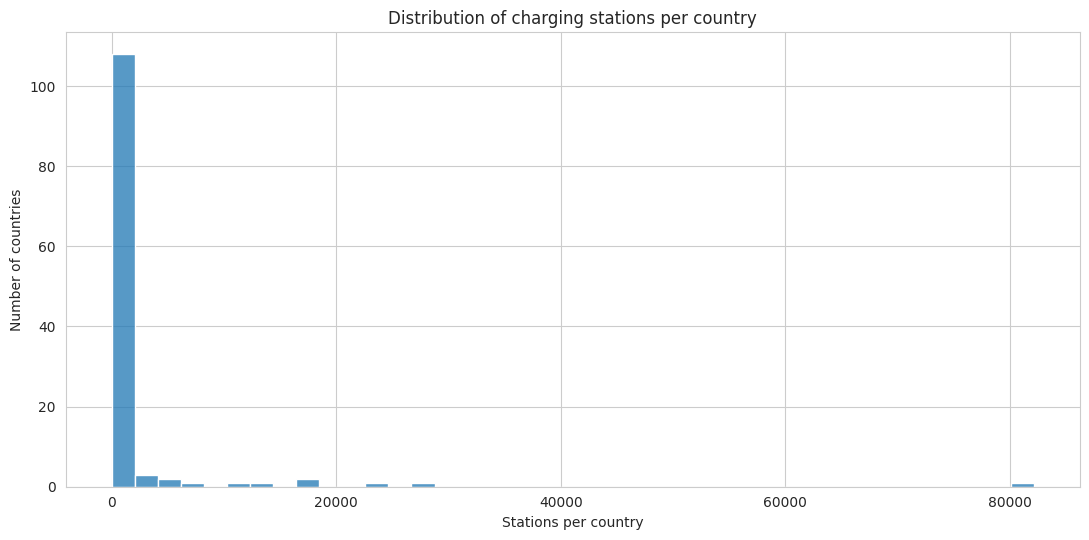

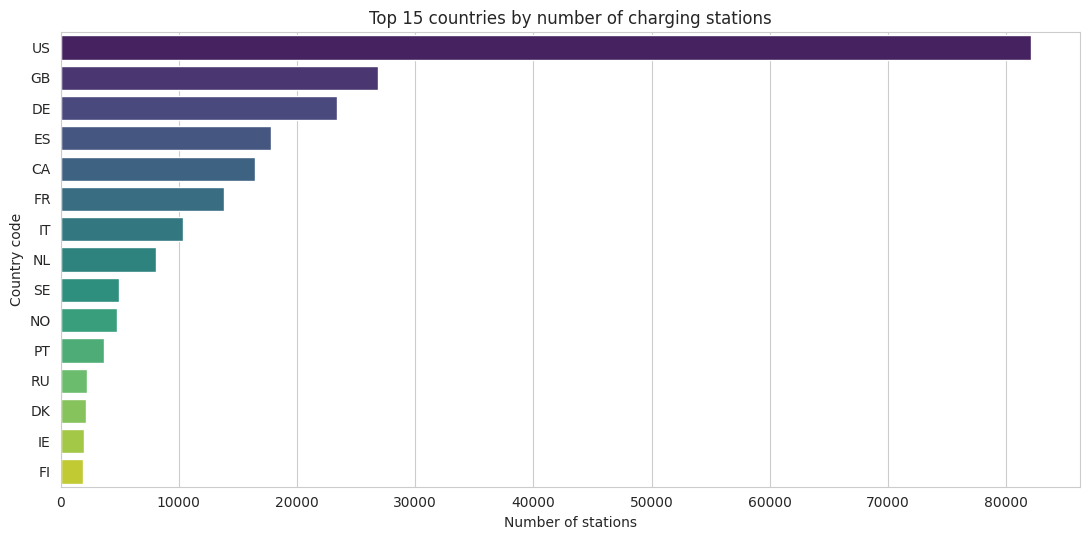

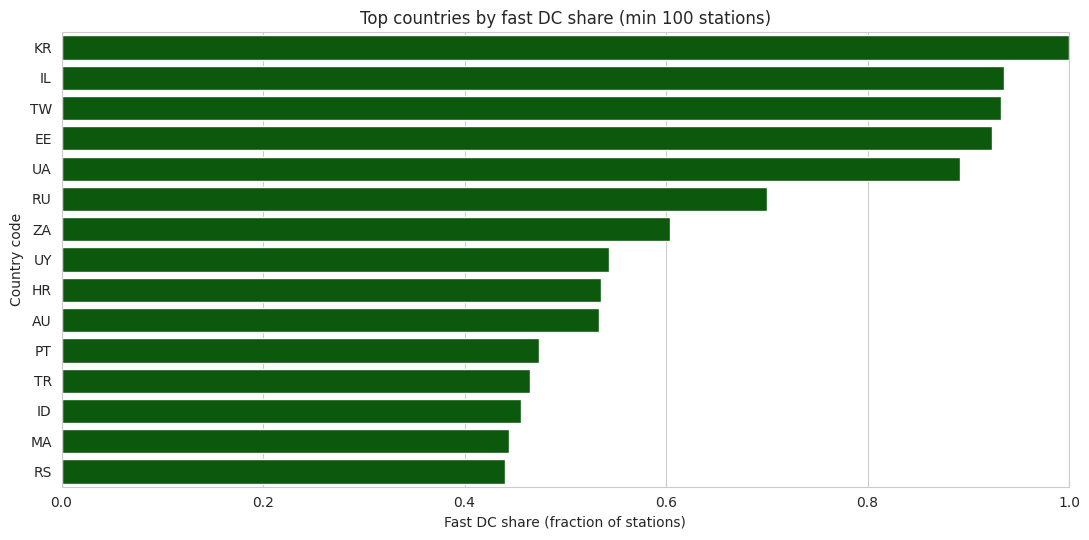

---

In [8]:
section(
    "Country coverage and fast DC share",
    "How many stations per country, and where is DC fast-charging common?"
)

# Distribution of stations per country
stations_per_country = country_dash["stations"]

plt.figure()
sns.histplot(stations_per_country, bins=40, kde=False)
plt.title("Distribution of charging stations per country")
plt.xlabel("Stations per country")
plt.ylabel("Number of countries")
plt.tight_layout()
plt.show()

# Top countries by station count
top_countries = country_dash.sort_values("stations", ascending=False).head(15)

plt.figure()
sns.barplot(
    data=top_countries,
    x="stations",
    y="country_code",
    order=top_countries["country_code"],
    palette="viridis"
)
plt.title("Top 15 countries by number of charging stations")
plt.xlabel("Number of stations")
plt.ylabel("Country code")
plt.tight_layout()
plt.show()

# Fast DC share (only stable where we have enough stations)
tmp = (
    country_dash
    .loc[country_dash["stations"] >= 100]
    .sort_values("fast_share", ascending=False)
    .head(15)
)

plt.figure()
sns.barplot(
    data=tmp,
    x="fast_share",
    y="country_code",
    order=tmp["country_code"],
    color="darkgreen"
)
plt.title("Top countries by fast DC share (min 100 stations)")
plt.xlabel("Fast DC share (fraction of stations)")
plt.ylabel("Country code")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

hr()


## Country typologies: coverage vs fast DC share

## Country typologies

Classifying countries by coverage (stations) and fast DC share.

,n_countries
typology,
High coverage / High fast share,35
High coverage / Low fast share,26
Low coverage / High fast share,26
Low coverage / Low fast share,34


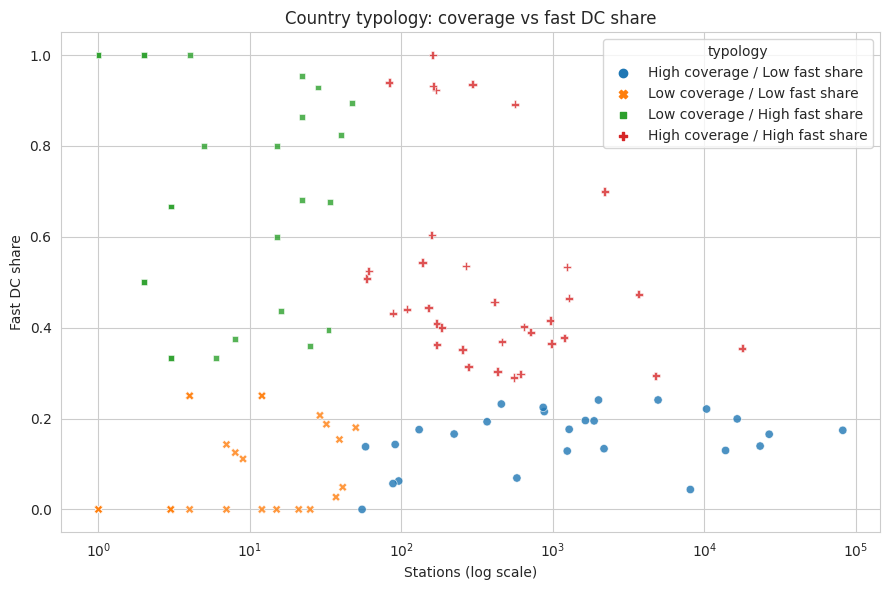

---

In [9]:
section(
    "Country typologies",
    "Classifying countries by coverage (stations) and fast DC share."
)

df_typo = country_dash.copy()

# Thresholds: median-based (can be tuned)
stations_thr = df_typo["stations"].median()
fast_share_thr = df_typo["fast_share"].median()

def coverage_level(x):
    return "High coverage" if x >= stations_thr else "Low coverage"

def fast_level(x):
    return "High fast share" if x >= fast_share_thr else "Low fast share"

df_typo["coverage"] = df_typo["stations"].apply(coverage_level)
df_typo["fast_level"] = df_typo["fast_share"].apply(fast_level)
df_typo["typology"] = df_typo["coverage"] + " / " + df_typo["fast_level"]

display(
    df_typo.groupby("typology")[["country_code"]].count().rename(columns={"country_code": "n_countries"})
)

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_typo,
    x="stations",
    y="fast_share",
    hue="typology",
    style="typology",
    alpha=0.8,
)
plt.xscale("log")
plt.xlabel("Stations (log scale)")
plt.ylabel("Fast DC share")
plt.title("Country typology: coverage vs fast DC share")
plt.tight_layout()
plt.show()

hr()


## Global view: station locations 


## Global view of station locations

A scatter plot of station coordinates.

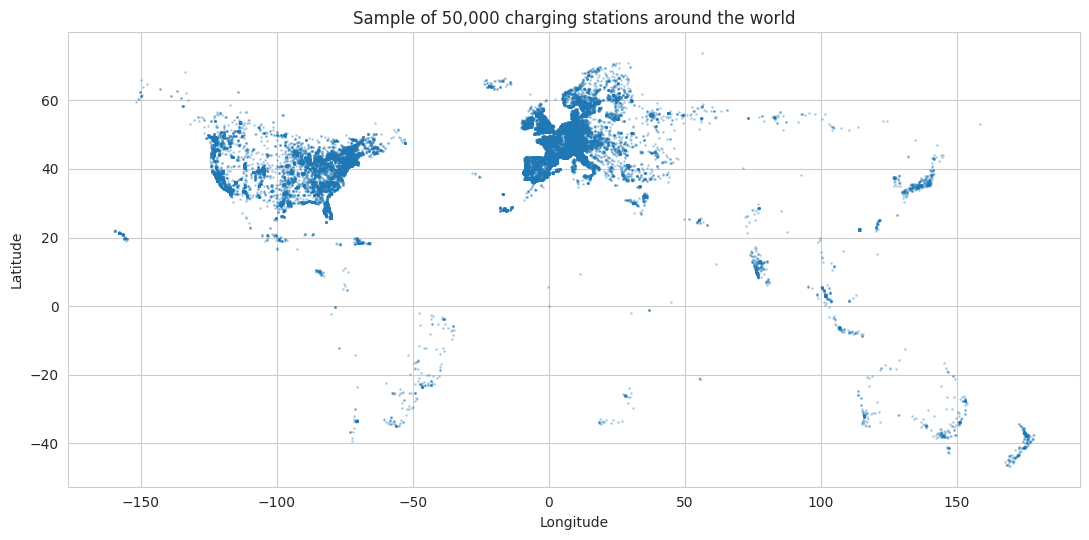

---

In [10]:
section(
    "Global view of station locations",
    "A scatter plot of station coordinates."
)

sample_size = min(50000, len(charging))
sample_geo = charging.sample(sample_size, random_state=SEED)

plt.figure(figsize=(11, 5.5))
plt.scatter(
    sample_geo["longitude"],
    sample_geo["latitude"],
    s=1,
    alpha=0.25,
)
plt.title(f"Sample of {sample_size:,} charging stations around the world")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

hr()


## Fast vs normal stations & power levels

## Fast DC vs Normal/AC stations

Counts, power buckets, and ports per station type.

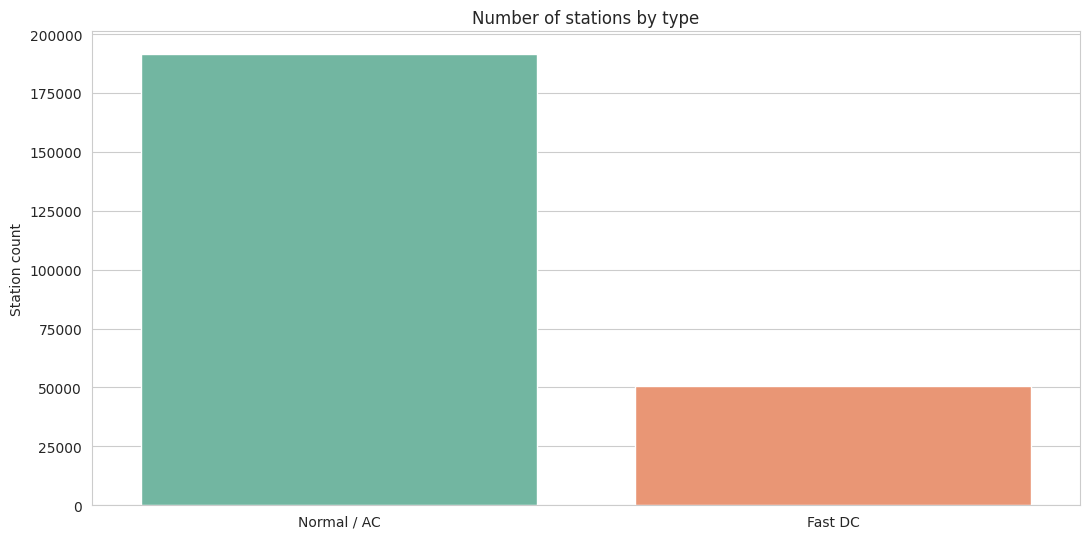

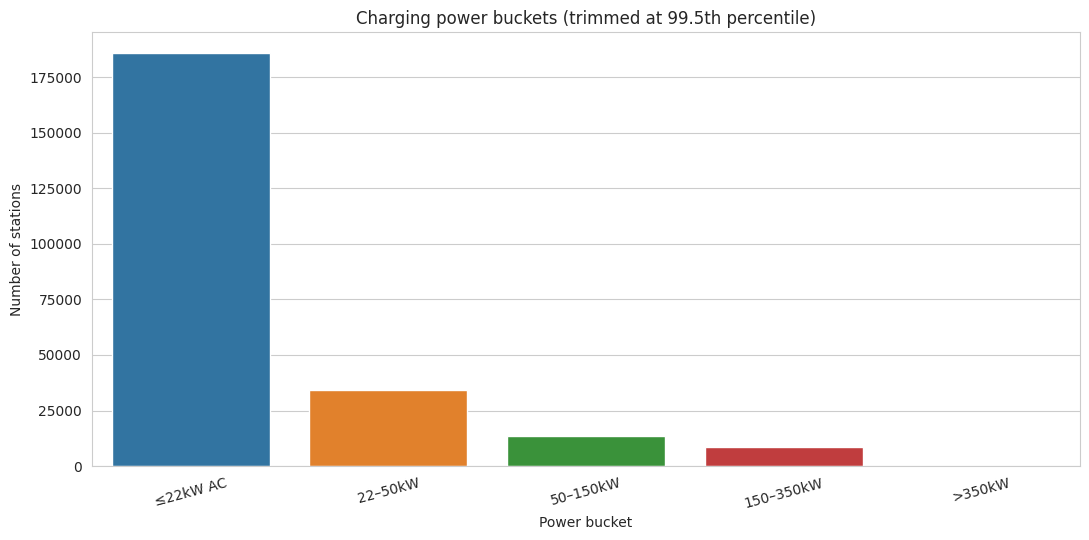

Average ports per station — Normal/AC: 1.70, Fast DC: 2.92


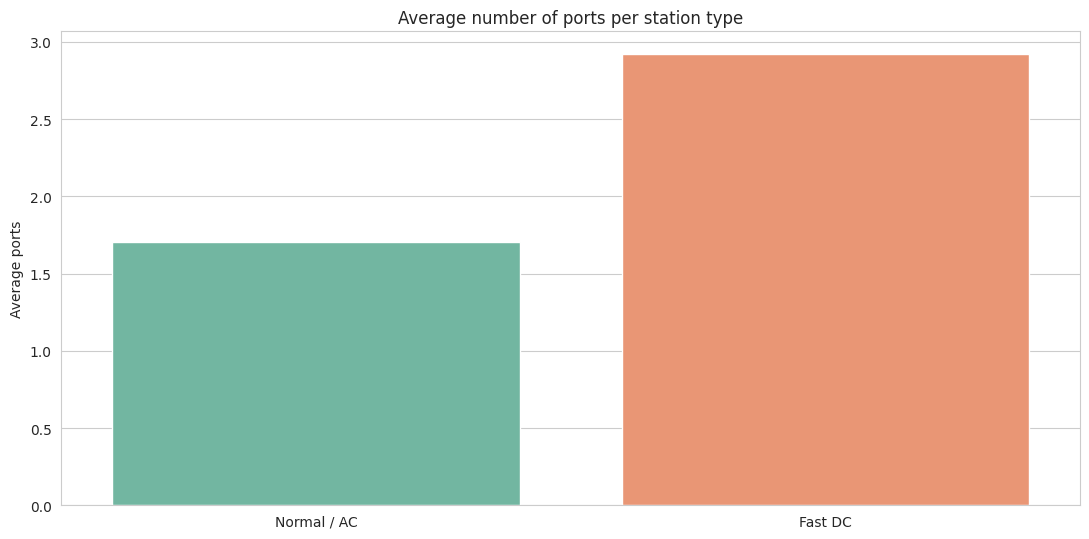

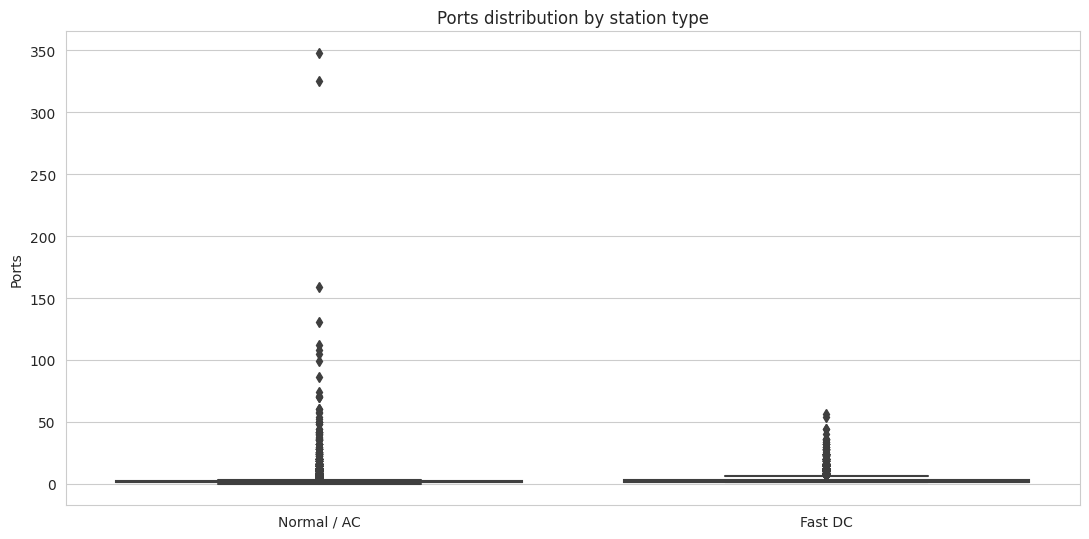

---

In [11]:
section(
    "Fast DC vs Normal/AC stations",
    "Counts, power buckets, and ports per station type."
)

# Counts by station type
counts = charging["is_fast_dc"].value_counts().reindex([False, True], fill_value=0)
labels = ["Normal / AC", "Fast DC"]

plt.figure()
sns.barplot(x=labels, y=counts.values, palette="Set2")
plt.title("Number of stations by type")
plt.xlabel("")
plt.ylabel("Station count")
plt.tight_layout()
plt.show()


# Power buckets
bucket_counts = (
    charging["power_bucket"]
    .value_counts()
    .reindex(power_labels, fill_value=0)
)

plt.figure()
sns.barplot(x=bucket_counts.index, y=bucket_counts.values)
plt.title("Charging power buckets (trimmed at 99.5th percentile)")
plt.xlabel("Power bucket")
plt.ylabel("Number of stations")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Average ports per station type
avg_ports_by_type = (
    charging.groupby("station_type")["ports"].mean().sort_values()
)

print(
    f"Average ports per station — "
    f"Normal/AC: {avg_ports_by_type.get('Normal / AC', np.nan):.2f}, "
    f"Fast DC: {avg_ports_by_type.get('Fast DC', np.nan):.2f}"
)

plt.figure()
sns.barplot(
    x=avg_ports_by_type.index,
    y=avg_ports_by_type.values,
    palette="Set2"
)
plt.title("Average number of ports per station type")
plt.xlabel("")
plt.ylabel("Average ports")
plt.tight_layout()
plt.show()

# Ports distribution by station type
plt.figure()
sample_ports = charging.sample(min(40000, len(charging)), random_state=SEED)
sns.boxplot(
    data=sample_ports,
    x="station_type",
    y="ports"
)
plt.title("Ports distribution by station type")
plt.xlabel("")
plt.ylabel("Ports")
plt.tight_layout()
plt.show()

hr()


## City-level infrastructure view

## City-level infrastructure view

Exploring stations and fast DC coverage at the city level.

City table shape: (58642, 17)


,country_code,state_province,city,latitude,longitude,station_count,port_count,fast_station_count,fast_port_count,fast_station_share,fast_port_share,max_power_kw,median_power_kw,dc_fast_station_count,dc_ultra_station_count,has_fast_dc,has_ultra_dc
0,AD,Andorra la Vella,Andorra la Vella,42.506880,1.527992,2,4,0,0,0.0,0.0,22.0,22.0,0,0,0,0
1,AD,Andorra la Vella,Santa Coloma,42.496959,1.500966,1,2,0,0,0.0,0.0,22.0,22.0,0,0,0,0
2,AD,Canillo,Canillo,42.565901,1.598916,1,2,0,0,0.0,0.0,22.0,22.0,0,0,0,0
3,AD,Canillo,Soldeu,42.577997,1.663842,1,2,0,0,0.0,0.0,4.0,4.0,0,0,0,0
4,AD,Encamp,Encamp,42.535057,1.581334,2,3,0,0,0.0,0.0,22.0,14.7,0,0,0,0


,station_count,port_count,fast_station_share,fast_port_share,max_power_kw,median_power_kw
count,58642.000000,58642.000000,58642.000000,58638.000000,56902.000000,56902.000000
mean,4.133846,8.099349,0.295128,0.305355,79.291555,57.661419
std,55.383509,72.007791,0.414020,0.420881,4192.756223,4192.410759
min,1.000000,-4.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,11.000000,7.200000
50%,1.000000,2.000000,0.000000,0.000000,22.000000,22.000000
75%,2.000000,6.000000,0.600000,0.750000,50.000000,50.000000
max,10354.000000,10594.000000,1.000000,1.000000,1000000.000000,1000000.000000


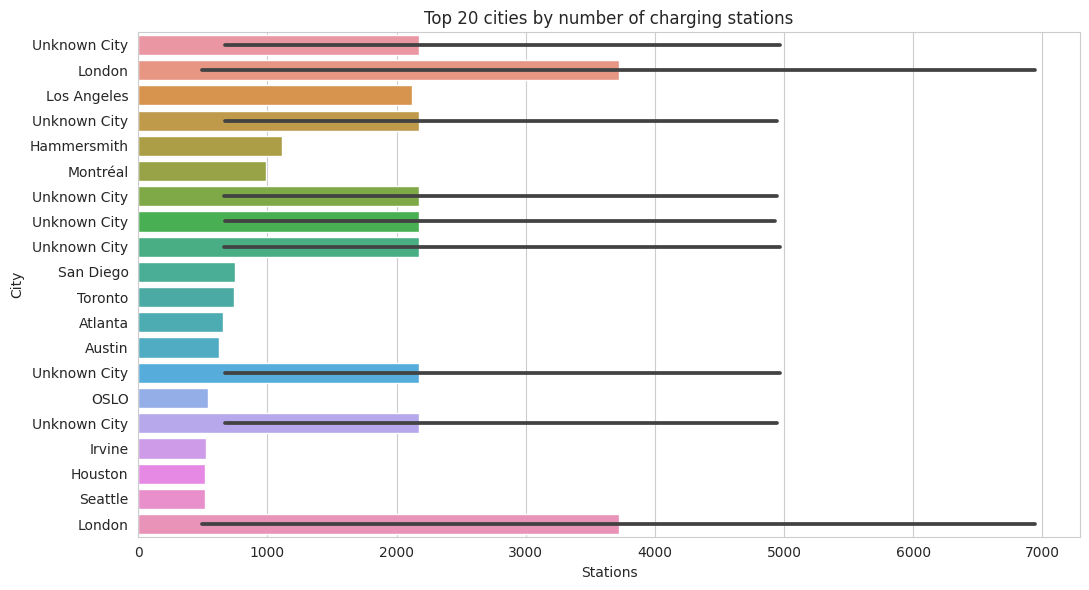

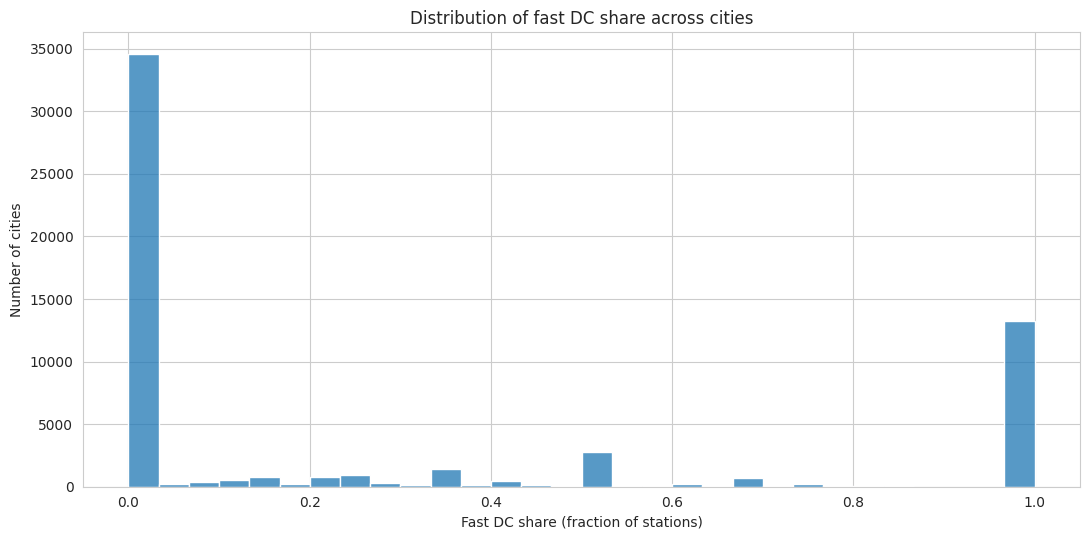

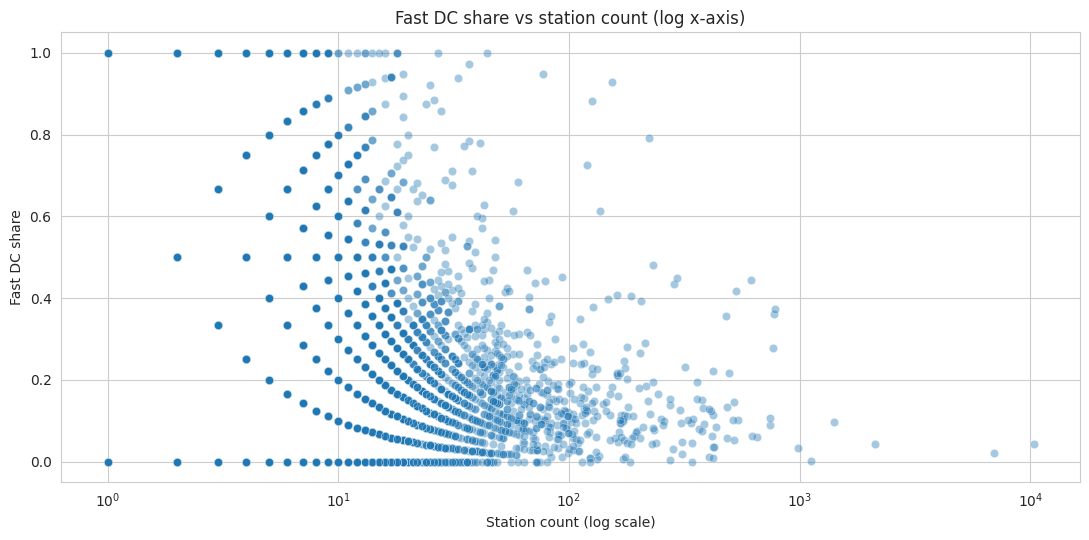

---

In [12]:
section(
    "City-level infrastructure view",
    "Exploring stations and fast DC coverage at the city level."
)

print("City table shape:", city.shape)
display(city.head())

display(
    city[[
        "station_count",
        "port_count",
        "fast_station_share",
        "fast_port_share",
        "max_power_kw",
        "median_power_kw",
    ]].describe()
)

# Top cities by station_count
top_cities = city.sort_values("station_count", ascending=False).head(20)

plt.figure(figsize=(11, 6))
sns.barplot(
    data=top_cities,
    x="station_count",
    y="city",
    order=top_cities["city"],
)
plt.title("Top 20 cities by number of charging stations")
plt.xlabel("Stations")
plt.ylabel("City")
plt.tight_layout()
plt.show()

# Distribution of fast_station_share
plt.figure()
sns.histplot(city["fast_station_share"], bins=30)
plt.title("Distribution of fast DC share across cities")
plt.xlabel("Fast DC share (fraction of stations)")
plt.ylabel("Number of cities")
plt.tight_layout()
plt.show()

# Relationship: station_count vs fast_station_share
plt.figure()
sns.scatterplot(
    data=city,
    x="station_count",
    y="fast_station_share",
    alpha=0.4,
)
plt.xscale("log")
plt.title("Fast DC share vs station count (log x-axis)")
plt.xlabel("Station count (log scale)")
plt.ylabel("Fast DC share")
plt.tight_layout()
plt.show()

hr()


## Consistency checks between station, city, and country tables

In [13]:
section(
    "Consistency checks",
    "Do aggregated counts from stations roughly match city and country tables?"
)

# 1) Stations → Country (from raw charging)
stations_by_country_from_raw = (
    charging.groupby("country_code")["id"].count().rename("stations_raw")
)

# 2) Stations → Country (from city table)
stations_by_country_from_city = (
    city.groupby("country_code")["station_count"].sum().rename("stations_city_sum")
)

consistency = (
    pd.concat([stations_by_country_from_raw, stations_by_country_from_city], axis=1)
    .dropna()
)
consistency["diff"] = consistency["stations_raw"] - consistency["stations_city_sum"]
consistency["rel_diff_pct"] = (
    consistency["diff"].abs() / consistency["stations_raw"].clip(lower=1) * 100
)

print("Consistency summary between raw stations and city-level station_count:")
display(consistency.describe()[["diff", "rel_diff_pct"]])

# Show largest relative differences
display(
    consistency.sort_values("rel_diff_pct", ascending=False).head(10)
)

hr()


## Consistency checks

Do aggregated counts from stations roughly match city and country tables?

Consistency summary between raw stations and city-level station_count:


,diff,rel_diff_pct
count,121.0,121.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


,stations_raw,stations_city_sum,diff,rel_diff_pct
country_code,,,,
AD,96,96,0,0.0
KH,22,22,0,0.0
PL,461,461,0,0.0
PK,3,3,0,0.0
PH,16,16,0,0.0
PE,7,7,0,0.0
PA,6,6,0,0.0
OM,22,22,0,0.0
NZ,978,978,0,0.0


---

## Baseline ML — City fast-DC presence


In [14]:
section(
    "Baseline ML — City fast-DC presence",
    "Logistic regression vs a dummy baseline to predict whether a city has any fast DC stations."
)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.dummy import DummyClassifier

# ---- 0) Guard: make sure target exists ----
if "has_fast_dc" not in city.columns:
    print("Column `has_fast_dc` not found in city table — skipping baseline ML block.")
    hr()
else:
    # ---- 1) Basic dataset summary ----
    target = city["has_fast_dc"].astype(int)
    pos_rate = target.mean()

    print(f"Cities in table: {len(city):,}")
    print(f"Share of cities with at least one fast DC station: {pct(pos_rate)}")

    # ---- 2) Features & split ----
    features = ["station_count", "port_count", "max_power_kw", "median_power_kw"]
    X = city[features].fillna(0)
    y = target

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.25, random_state=SEED, stratify=y
    )

    # Container for metrics
    metrics = {}

    # ---- 3) Dummy baseline: always predict majority class ----
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)

    y_dummy = dummy.predict(X_valid)
    # Use a constant probability equal to the positive rate in train set
    y_dummy_proba = np.full_like(y_dummy, y_train.mean(), dtype=float)

    metrics["Dummy (majority class)"] = {
        "ROC-AUC": roc_auc_score(y_valid, y_dummy_proba),
        "Accuracy": accuracy_score(y_valid, y_dummy),
    }

    # ---- 4) Baseline model: Logistic Regression ----
    clf = LogisticRegression(max_iter=1000, class_weight="balanced")
    clf.fit(X_train, y_train)

    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    metrics["Logistic (city baseline)"] = {
        "ROC-AUC": roc_auc_score(y_valid, y_pred_proba),
        "Accuracy": accuracy_score(y_valid, y_pred),
    }

    # ---- 5) Compare models in a single table ----
    results_df = (
        pd.DataFrame(metrics)
        .T[["ROC-AUC", "Accuracy"]]
        .round(3)
        .sort_values("ROC-AUC", ascending=False)
    )

    print("\nValidation performance comparison:")
    display(results_df)

    # ---- 6) Coefficients as simple feature effects ----
    coef_df = (
        pd.DataFrame({"feature": features, "coef": clf.coef_[0]})
        .sort_values("coef", key=np.abs, ascending=False)
        .reset_index(drop=True)
    )

    print("\nFeature effects (log-odds coefficients for the positive class):")
    display(coef_df)

    hr()


## Baseline ML — City fast-DC presence

Logistic regression vs a dummy baseline to predict whether a city has any fast DC stations.

Cities in table: 58,642
Share of cities with at least one fast DC station: 41.2%

Validation performance comparison:


,ROC-AUC,Accuracy
Logistic (city baseline),1.0,1.000
Dummy (majority class),0.5,0.588



Feature effects (log-odds coefficients for the positive class):


,feature,coef
0,max_power_kw,5.910998
1,station_count,0.144253
2,port_count,0.037452
3,median_power_kw,-0.012060


---

## City clustering: infrastructure profiles

## City clusters

Grouping cities into infrastructure profiles with KMeans.

,station_count,port_count,fast_station_share,fast_port_share,max_power_kw,median_power_kw
cluster,,,,,,
0,2.15,5.95,0.89,0.92,124.42,97.40
1,4.56,8.56,0.04,0.04,33.70,14.48
2,8649.50,9488.00,0.03,0.05,237.50,13.40
3,1.00,1.00,1.00,1.00,1000000.00,1000000.00


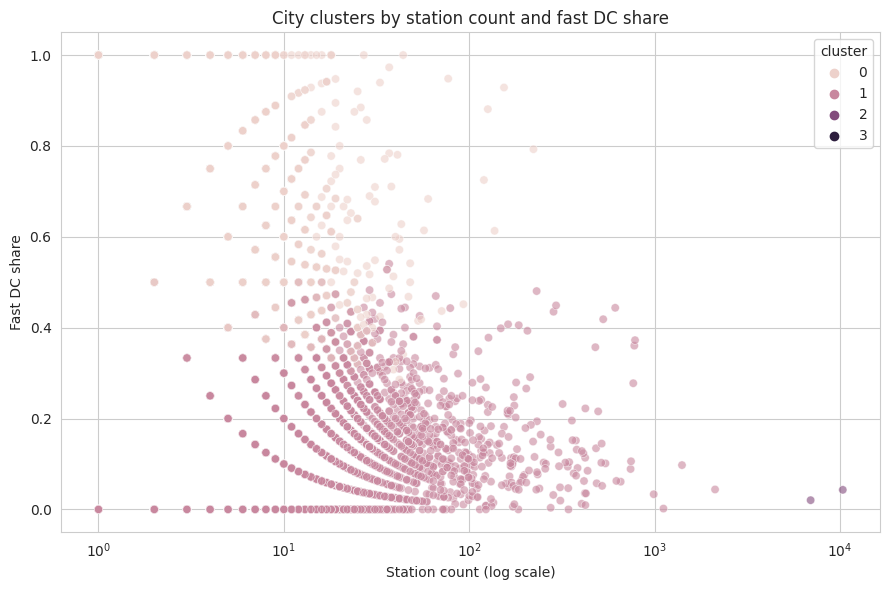

---

In [15]:
section(
    "City clusters",
    "Grouping cities into infrastructure profiles with KMeans."
)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Choose features for clustering
cluster_features = [
    "station_count",
    "port_count",
    "fast_station_share",
    "fast_port_share",
    "max_power_kw",
    "median_power_kw",
]

city_clust = city.copy()
X = city_clust[cluster_features].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try a small number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=SEED, n_init=10)
city_clust["cluster"] = kmeans.fit_predict(X_scaled)

# Cluster-level summary
cluster_summary = (
    city_clust
    .groupby("cluster")[cluster_features]
    .mean()
    .round(2)
    .sort_index()
)

display(cluster_summary)

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=city_clust,
    x="station_count",
    y="fast_station_share",
    hue="cluster",
    alpha=0.6,
)
plt.xscale("log")
plt.xlabel("Station count (log scale)")
plt.ylabel("Fast DC share")
plt.title("City clusters by station count and fast DC share")
plt.tight_layout()
plt.show()

hr()


## EV models: timeline, brands, and body styles

## EV models overview

Timeline of models, top manufacturers, and body styles.

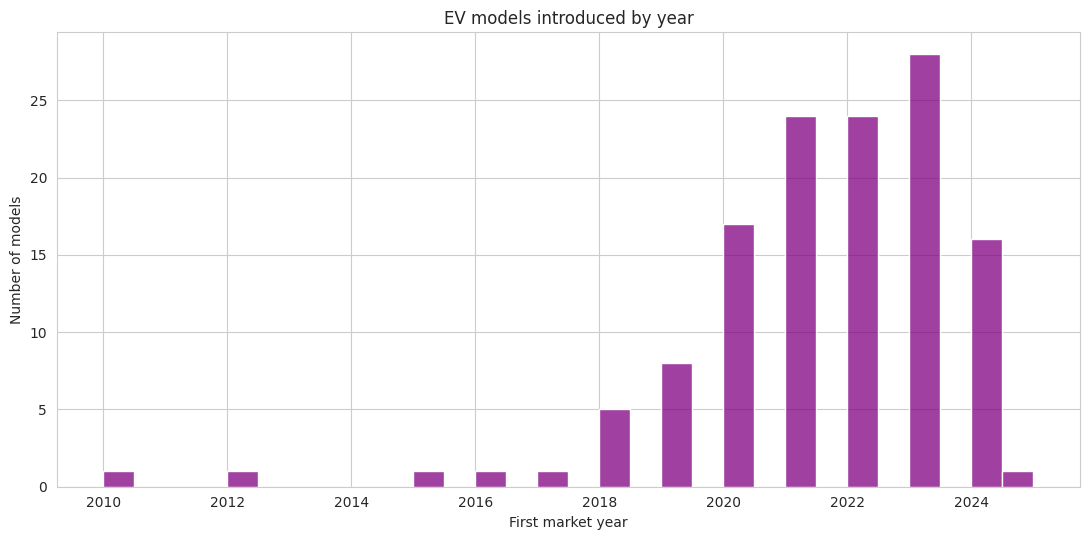

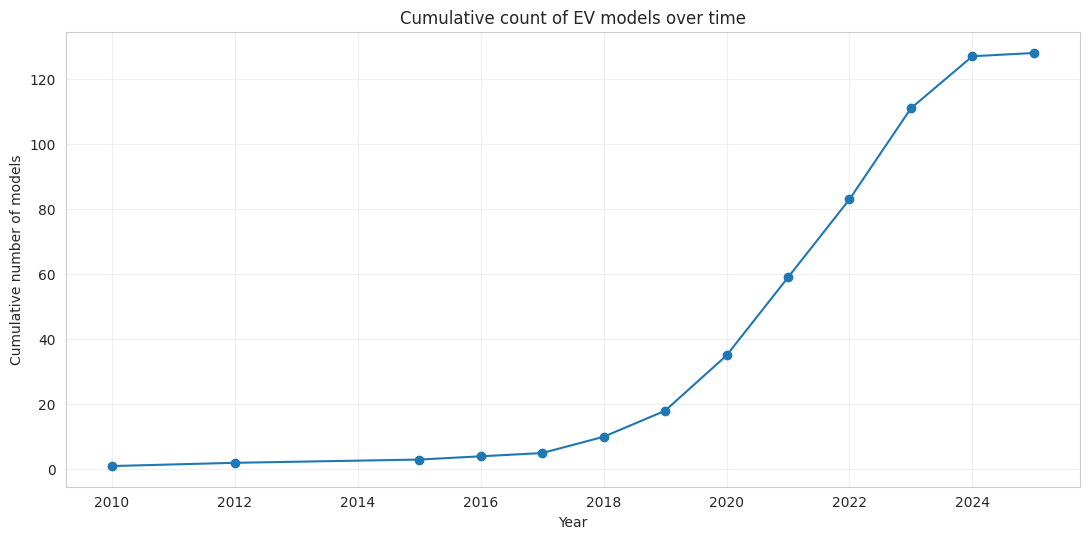

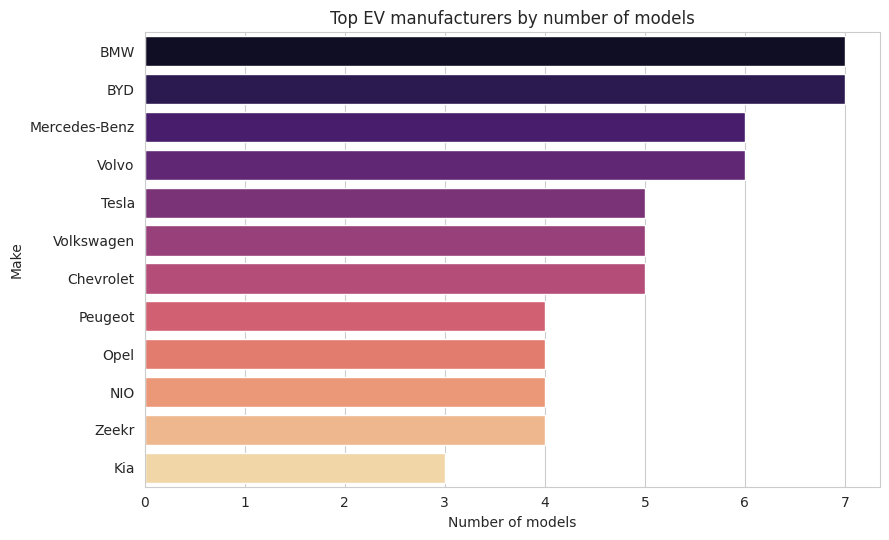

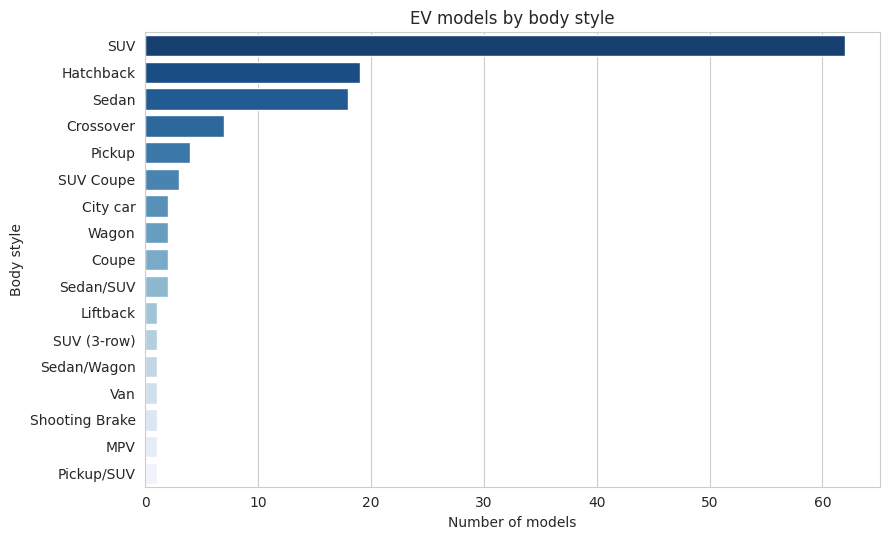

---

In [16]:

section(
    "EV models overview",
    "Timeline of models, top manufacturers, and body styles."
)

# Timeline of first_year
ev_years = ev_models["first_year"].dropna().astype(int)

plt.figure()
sns.histplot(ev_years, bins=30, color="purple")
plt.title("EV models introduced by year")
plt.xlabel("First market year")
plt.ylabel("Number of models")
plt.tight_layout()
plt.show()

# Cumulative models over time
s = ev_years.value_counts().sort_index()
cum = s.cumsum()

plt.figure()
plt.plot(cum.index, cum.values, marker="o")
plt.title("Cumulative count of EV models over time")
plt.xlabel("Year")
plt.ylabel("Cumulative number of models")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Top makes
top_makes = ev_models["make"].value_counts().head(12)

plt.figure(figsize=(9, 5.5))
sns.barplot(
    x=top_makes.values,
    y=top_makes.index,
    palette="magma"
)
plt.title("Top EV manufacturers by number of models")
plt.xlabel("Number of models")
plt.ylabel("Make")
plt.tight_layout()
plt.show()

# Body styles
body_counts = ev_models["body_style"].value_counts()

plt.figure(figsize=(9, 5.5))
sns.barplot(
    x=body_counts.values,
    y=body_counts.index,
    palette="Blues_r"
)
plt.title("EV models by body style")
plt.xlabel("Number of models")
plt.ylabel("Body style")
plt.tight_layout()
plt.show()

hr()


## Correlation between country-level metrics


## Country-level correlations

How do high-level infrastructure metrics relate to each other?

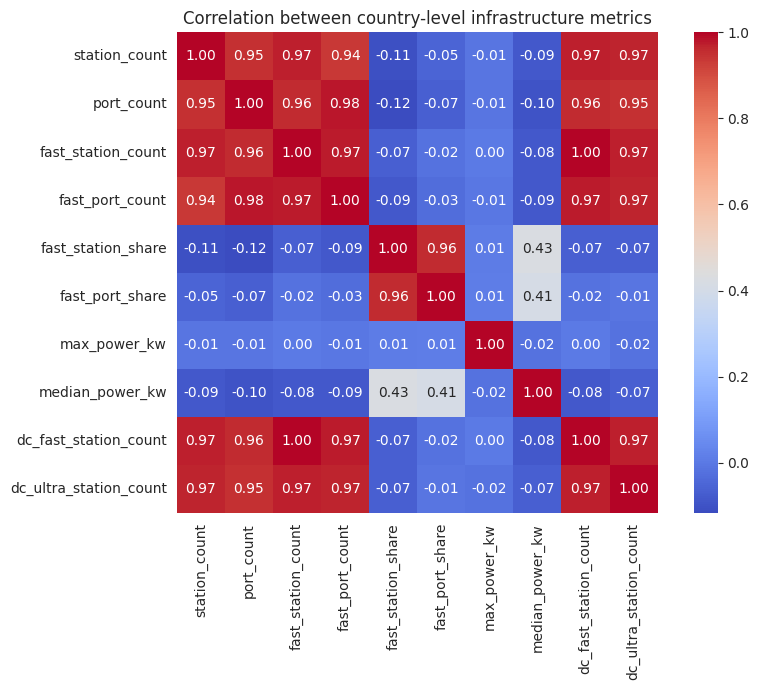

---

In [17]:
section(
    "Country-level correlations",
    "How do high-level infrastructure metrics relate to each other?"
)

num_cols = world.select_dtypes("number").columns
corr = world[num_cols].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation between country-level infrastructure metrics")
plt.tight_layout()
plt.show()

hr()


## Linking EV origin_country to infrastructure

## EV origin vs infrastructure

Relating EV model count to charging stations by country code.

,country_code,stations,ports,fast_share,n_models
2,DE,23373,46401,0.139434,13
9,US,82138,113480,0.174085,13
0,CN,12,28,0.250000,9
7,KR,161,1098,1.000000,6
6,JP,1641,2158,0.195612,5
4,FR,13820,21932,0.129740,4
8,SE,4953,30622,0.240864,4
1,CZ,555,803,0.290090,1
3,ES,17825,53762,0.354783,1
5,IT,10354,22305,0.220977,1


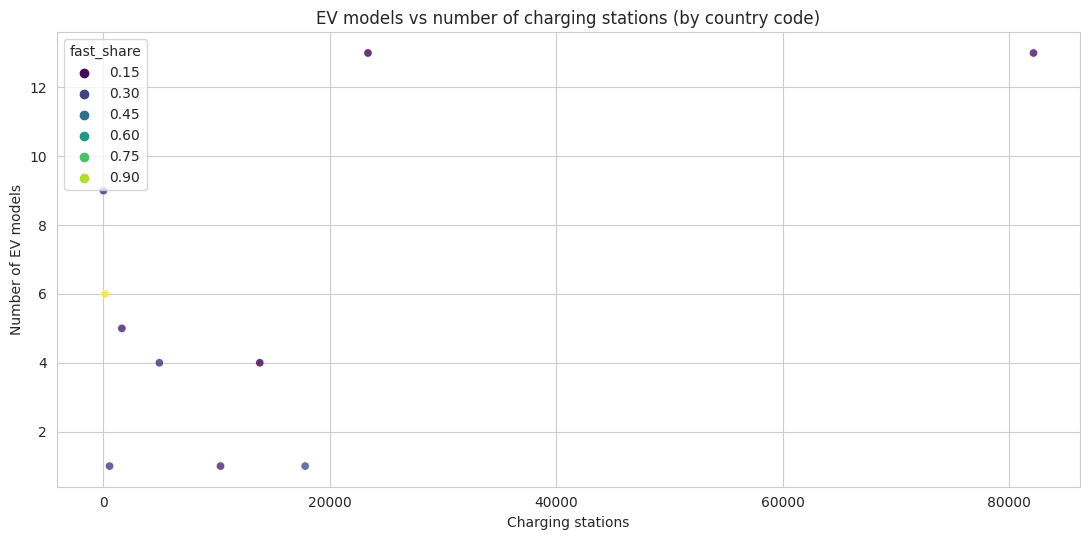

---

In [18]:
section(
    "EV origin vs infrastructure",
    "Relating EV model count to charging stations by country code."
)

# Infrastructure by country from our dashboard
infra_by_country = (
    country_dash[["country_code", "stations", "ports", "fast_share"]]
    .copy()
)

# EV models by origin_country (assuming ISO-2 codes where possible)
models_by_origin = (
    ev_models["origin_country"]
    .value_counts()
    .rename_axis("country_code")
    .reset_index(name="n_models")
)

infra_models = infra_by_country.merge(
    models_by_origin,
    on="country_code",
    how="inner"
)

if len(infra_models) > 0:
    display(infra_models.sort_values("n_models", ascending=False).head(10))

    plt.figure()
    sns.scatterplot(
        data=infra_models,
        x="stations",
        y="n_models",
        hue="fast_share",
        palette="viridis",
        alpha=0.8
    )
    plt.title("EV models vs number of charging stations (by country code)")
    plt.xlabel("Charging stations")
    plt.ylabel("Number of EV models")
    plt.tight_layout()
    plt.show()
else:
    print(
        "No overlap between `origin_country` in EV models and `country_code` "
        "in infrastructure. This view is empty with the current encoding."
    )

hr()


## Final numerical insight pack

In [19]:
section("Final numerical insight pack")

countries_covered = charging["country_code"].nunique()
cities_covered = charging["city"].nunique()
fast_share_global = charging["is_fast_dc"].mean()
max_power = charging["power_kw"].max()
p99_power = charging["power_kw"].quantile(0.99)

top_make_counts = ev_models["make"].value_counts()
top_make = top_make_counts.idxmax() if len(top_make_counts) else None
top_make_n = top_make_counts.max() if len(top_make_counts) else 0

print("-" * 60)
print("Global infrastructure snapshot:")
print(f"- Total stations: {len(charging):,}")
print(f"- Countries with stations: {countries_covered}")
print(f"- Cities with stations: {cities_covered}")
print(f"- Global fast DC share: {pct(fast_share_global)} of stations")
print(f"- Max site power: {max_power:,.0f} kW")
print(f"- 99th percentile site power: {p99_power:,.0f} kW")

if top_make is not None:
    print(f"- Top EV make by number of models: {top_make} ({top_make_n} models)")
else:
    print("- No EV make information available.")

print("-" * 60)


## Final numerical insight pack

------------------------------------------------------------
Global infrastructure snapshot:
- Total stations: 242,417
- Countries with stations: 121
- Cities with stations: 41816
- Global fast DC share: 21.0% of stations
- Max site power: 1,000,000 kW
- 99th percentile site power: 350 kW
- Top EV make by number of models: BMW (7 models)
------------------------------------------------------------


<style>
:root{
  --ink:#0f172a;
  --muted:#475569;
  --border:rgba(15,23,42,0.18);
  --shadow:0 20px 50px rgba(2,6,23,0.10);
  --bg:
    radial-gradient(900px 500px at 0% 0%, rgba(2,132,199,0.16) 0, transparent 55%),
    linear-gradient(135deg, #ffffff 0%, #f1f5f9 55%, #ffffff 100%);
}
@media (prefers-color-scheme: dark){
  :root{
    --ink:#eaf2ff;
    --muted:#9ca3af;
    --border:rgba(148,163,184,0.55);
    --shadow:0 20px 50px rgba(15,23,42,0.85);
    --bg:
      radial-gradient(900px 500px at 0% 0%, rgba(37,99,235,0.32) 0, transparent 55%),
      linear-gradient(135deg, #020617 0%, #02091f 55%, #020617 100%);
  }
}
html[data-color-mode="dark"],
html[data-theme="dark"],
body[data-theme="dark"],
body.theme-dark,
html.theme-dark{
  --ink:#eaf2ff;
  --muted:#9ca3af;
  --border:rgba(148,163,184,0.55);
  --shadow:0 20px 50px rgba(15,23,42,0.85);
  --bg:
    radial-gradient(900px 500px at 0% 0%, rgba(37,99,235,0.32) 0, transparent 55%),
    linear-gradient(135deg, #020617 0%, #02091f 55%, #020617 100%);
}
html[data-color-mode="light"],
html[data-theme="light"],
body[data-theme="light"],
body.theme-light,
html.theme-light{
  --ink:#0f172a;
  --muted:#475569;
  --border:rgba(15,23,42,0.18);
  --shadow:0 20px 50px rgba(2,6,23,0.10);
  --bg:
    radial-gradient(900px 500px at 0% 0%, rgba(2,132,199,0.16) 0, transparent 55%),
    linear-gradient(135deg, #ffffff 0%, #f1f5f9 55%, #ffffff 100%);
}
.kgl-take{
  background:var(--bg) !important;
  color:var(--ink) !important;
  border-radius:22px;
  padding:30px 34px;
  border:1px solid var(--border) !important;
  box-shadow:var(--shadow) !important;
  line-height:1.7;
  margin-top:26px;
  margin-bottom:34px;
}
.kgl-take *{ color:var(--ink) !important; }
.kgl-take .kgl-muted{ color:var(--muted) !important; }
</style>

<div class="kgl-take">

  <h2 style="margin:0 0 14px 0; font-size:22px; font-weight:800;">
    Takeaways &amp; where to go next
  </h2>

  <h3 class="kgl-muted" style="margin:0 0 10px 0; font-size:16px; font-weight:700;">
    What this notebook delivers
  </h3>

  <ul style="margin:0 0 16px 1.1rem; padding-left:1.1rem; font-size:14px;">
    <li>
      A consistent, cleaned view of the global charging network &mdash; from individual stations
      to cities and countries &mdash; with sanity checks on coordinates, types, and coverage.
    </li>
    <li>
      A country-level infrastructure profile that highlights how uneven the landscape is:
      a handful of markets concentrate a large share of stations, while many regions remain lightly covered.
    </li>
    <li>
      Evidence that fast DC is still a minority of global sites, but that its share jumps sharply
      in high-density, mature markets and in cities that cross certain station-count thresholds.
    </li>
    <li>
      A city-level table that already behaves like an ML-ready feature set &mdash; station counts, ports,
      fast shares, and power statistics &mdash; plus a baseline model that can distinguish cities with and
      without fast DC infrastructure.
    </li>
    <li>
      An EV model perspective (timeline, brands, body styles) that shows how the vehicle ecosystem
      has accelerated and how a few manufacturers dominate model variety.
    </li>
  </ul>

  <h3 class="kgl-muted" style="margin:0 0 10px 0; font-size:16px; font-weight:700;">
    High-impact directions to extend this work
  </h3>

  <ul style="margin:0 0 16px 1.1rem; padding-left:1.1rem; font-size:14px;">
    <li>
      Join this dataset with population, GDP, or vehicle-fleet statistics to build
      <b>per-capita</b>, <b>per-vehicle</b>, or <b>per-EV</b> coverage metrics and rank regions
      by infrastructure adequacy.
    </li>
    <li>
      Turn the city table into a richer modeling sandbox: train tree-based models to predict
      <b>where fast DC expansion is most likely or most needed</b> and compare different feature sets,
      thresholds, and cost assumptions.
    </li>
    <li>
      Define simple <b>coverage / gap indices</b> (e.g., stations per 100k people vs. fast DC share)
      to flag under-served countries or cities for planning and policy analysis.
    </li>
    <li>
      Build an interactive dashboard (Plotly, Streamlit, or BI tools) on top of the same tables to
      let users explore countries, cities, power tiers, and EV brands in real time.
    </li>
  </ul>

  <p style="margin:0; font-size:14px;">
    Together with the underlying dataset, this notebook acts as a reusable reference: a clean set of tables,
    core visual views, and a first baseline model that make it easy to prototype infrastructure scenarios,
    planning tools, and more advanced machine learning experiments on top of the global EV ecosystem.
  </p>

</div>
